In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy


/home/sam/Documents/projects/practice/fastapi/fastapi/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
2024-05-12 23:36:26.270484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 23:36:27.534627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:
2024-05-12 23:36:27.534750: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64]

In [2]:
series = read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 1 average .csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values = series.values



In [3]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [4]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [5]:


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [6]:
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


2024-05-12 23:36:29.987060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 23:36:30.057108: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:
2024-05-12 23:36:30.057153: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-05-12 23:36:30.057713: I tensorflow/core/platform/cpu_feature_guard.cc:193] 

44/44 [==============================] - 0s 1ms/step


array([[ 0.19825138],
       [-0.16517657],
       [ 0.29942095],
       [ 0.504766  ],
       [-0.13134333],
       [ 0.19111456],
       [-0.08104274],
       [ 0.40551686],
       [ 0.08688728],
       [ 0.13938086],
       [ 0.48822927],
       [ 0.49981207],
       [-0.07442752],
       [ 0.15102911],
       [ 0.5402695 ],
       [ 0.01995769],
       [ 0.13785532],
       [ 0.01347291],
       [ 0.06106214],
       [ 0.06301959],
       [ 0.05915528],
       [-0.21062365],
       [-0.25858358],
       [-0.1224699 ],
       [-0.18625027],
       [ 0.16300288],
       [ 0.22965744],
       [-0.0831477 ],
       [-0.17743185],
       [ 0.20851019],
       [ 0.86219716],
       [-0.1125184 ],
       [ 0.00204553],
       [-0.19567606],
       [-0.13689688],
       [-0.32696638],
       [-0.46778002],
       [ 0.39040112],
       [-0.12419599],
       [-0.29982582],
       [ 0.24747828],
       [-0.05832922],
       [-0.23139697],
       [ 0.18299727]], dtype=float32)

In [7]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 14ms/step
Month=1, Predicted=275.816959, Expected=275.539862
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=275.644205, Expected=274.678387
1/1 [==============================] - 0s 14ms/step
Month=3, Predicted=275.657022, Expected=275.965119


Test RMSE: 0.607


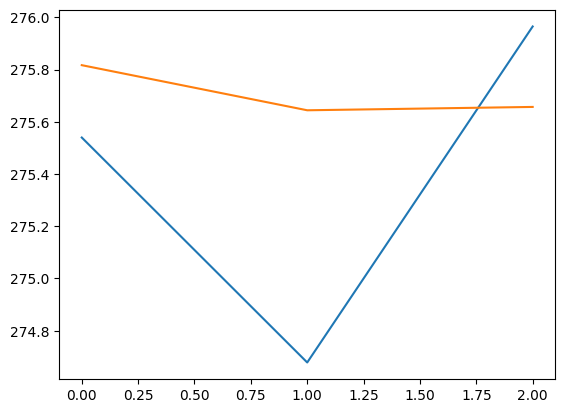

In [8]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()